In [24]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch import tensor # Embora 'tensor' não seja usado diretamente no código subsequente, mantendo como no original
import torch # Adicionado para torch.max e torch.no_grad
import os # Para manipulação de caminhos de arquivo
import numpy as np # Para np.random e np.array
import pandas as pd # Para criar DataFrames
import glob # Para listar arquivos
from sklearn.metrics import precision_score, recall_score # Para métricas de avaliação

Formato original da imagem do DataLoader: torch.Size([1, 3, 128, 128])
Formato da imagem para plotagem: torch.Size([128, 128, 3])


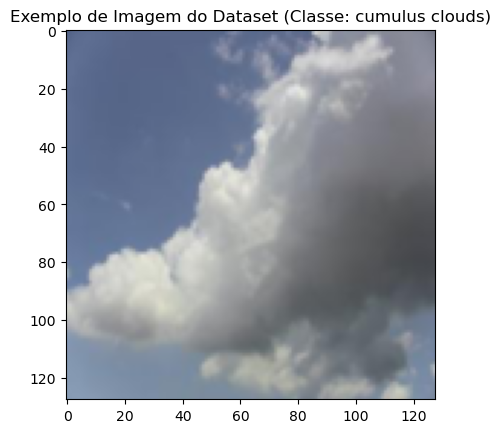

In [25]:
# Define as transformações iniciais para o conjunto de treino
# Apenas converte para Tensor e redimensiona para 128x128 pixels
initial_train_transforms = transforms.Compose(
    [
        transforms.ToTensor(), # Converte a imagem PIL para um tensor PyTorch (normaliza para [0,1])
        transforms.Resize((128, 128)), # Redimensiona todas as imagens para 128x128 pixels
    ]
)

# Carrega o dataset de treino usando ImageFolder
# ImageFolder assume que as imagens estão organizadas em subpastas por classe
dataset_train_initial = ImageFolder(
    "clouds/clouds_test", # Caminho para a pasta de treino
    transform=initial_train_transforms, # Aplica as transformações definidas
)

# Cria um DataLoader para o conjunto de treino inicial
# DataLoader ajuda a carregar os dados em batches e embaralhá-los
dataloader_train_initial = DataLoader(
    dataset_train_initial,
    shuffle=True, # Embaralha os dados a cada época
    batch_size=1, # Carrega uma imagem por vez (para visualização)
)

# Pega um batch (uma imagem e seu rótulo) do DataLoader
image, label = next(iter(dataloader_train_initial))
print(f"Formato original da imagem do DataLoader: {image.shape}") # Saída esperada: torch.Size([1, 3, 128, 128]) (batch_size, canais, altura, largura)

# Remove a dimensão do batch (squeeze) e reordena as dimensões para visualização com Matplotlib
# Matplotlib espera (altura, largura, canais)
image_for_plot = image.squeeze().permute(1, 2, 0)
print(f"Formato da imagem para plotagem: {image_for_plot.shape}") # Saída esperada: torch.Size([128, 128, 3])

# Mostra a imagem
plt.imshow(image_for_plot)
plt.title(f"Exemplo de Imagem do Dataset (Classe: {dataset_train_initial.classes[label.item()]})")
plt.show()

Esta célula importa as bibliotecas necessárias e realiza o carregamento inicial dos dados de treinamento.

ImageFolder: Uma classe útil do torchvision que carrega imagens de um diretório onde cada subdiretório representa uma classe.

- transforms.Compose: Agrupa múltiplas transformações.
- transforms.ToTensor(): Converte uma imagem PIL (Python Imaging Library) ou NumPy ndarray no intervalo [0, 255] para um tensor PyTorch torch.FloatTensor no intervalo [0.0, 1.0].
- transforms.Resize((128, 128)): Redimensiona a imagem para um tamanho fixo.
- DataLoader: Cria um iterador sobre o dataset, permitindo carregar dados em batches, embaralhar e usar paralelização.
Visualizamos uma imagem para verificar se o carregamento está correto. A função .permute(1, 2, 0) é necessária porque o PyTorch lida com imagens como (Canais, Altura, Largura), enquanto matplotlib.pyplot.imshow espera (Altura, Largura, Canais).

Formato da imagem aumentada do DataLoader: torch.Size([1, 3, 128, 128])
Formato da imagem aumentada para plotagem: torch.Size([128, 128, 3])


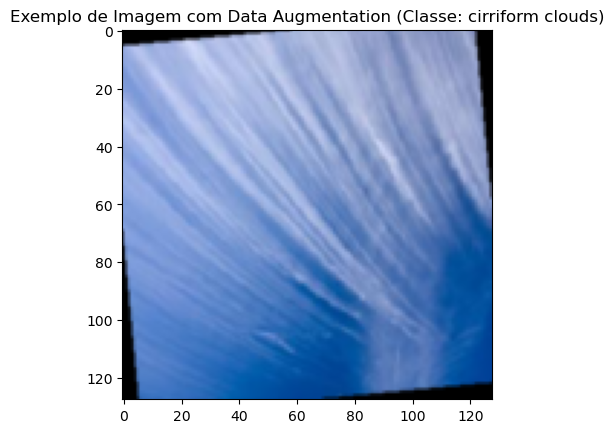

In [26]:
# Define transformações de Data Augmentation para o conjunto de treino
# Data Augmentation ajuda a prevenir overfitting e a tornar o modelo mais robusto
train_transforms_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Inverte horizontalmente a imagem com uma probabilidade de 0.5
    transforms.RandomRotation(45),     # Rotaciona a imagem aleatoriamente em até 45 graus
    transforms.RandomAutocontrast(),   # Ajusta o contraste da imagem aleatoriamente
    transforms.ToTensor(),             # Converte para Tensor
    transforms.Resize((128, 128)),     # Redimensiona para 128x128 (mantendo o mesmo tamanho da visualização anterior)
])

# Carrega o dataset de treino com as transformações de Data Augmentation
dataset_train_augmented = ImageFolder(
    "clouds/clouds_train", # Caminho para a pasta de treino
    transform=train_transforms_augmented, # Aplica as novas transformações
)

# Cria um DataLoader para o conjunto de treino aumentado
dataloader_train_augmented = DataLoader(
  dataset_train_augmented, shuffle=True, batch_size=1 # Batch size 1 para visualização
)

# Pega uma imagem transformada do DataLoader
image_aug, label_aug = next(iter(dataloader_train_augmented))
print(f"Formato da imagem aumentada do DataLoader: {image_aug.shape}")

# Prepara para plotagem
image_aug_for_plot = image_aug.squeeze().permute(1,2,0)
print(f"Formato da imagem aumentada para plotagem: {image_aug_for_plot.shape}")

# Mostra a imagem aumentada
plt.imshow(image_aug_for_plot)
plt.title(f"Exemplo de Imagem com Data Augmentation (Classe: {dataset_train_augmented.classes[label_aug.item()]})")
plt.show()

Data Augmentation é uma técnica usada para aumentar artificialmente o tamanho e a diversidade do conjunto de dados de treinamento. Isso é feito aplicando transformações aleatórias às imagens existentes.

- `RandomHorizontalFlip`: Vira a imagem horizontalmente.
- `RandomRotation`: Rotaciona a imagem em um ângulo aleatório.
- `RandomAutocontrast`: Melhora o contraste da imagem de forma aleatória. Essas técnicas ajudam o modelo a generalizar melhor para dados não vistos, pois ele aprende a ser invariante a essas pequenas variações.

In [27]:
class Net(nn.Module):
    def __init__(self, num_classes):
        # Chama o construtor da classe pai (nn.Module)
        super().__init__()

        # Define a parte da rede responsável pela extração de características (feature extractor)
        # nn.Sequential é um contêiner de módulos que serão executados na ordem definida
        self.feature_extractor = nn.Sequential(
            # Primeira camada convolucional:
            # - Recebe 3 canais de entrada (RGB, pois as imagens são coloridas)
            # - Produz 32 canais de saída (ou seja, 32 mapas de características)
            # - Usa um kernel (filtro) de tamanho 3x3 para realizar a convolução
            # - Aplica padding de 1 para que as dimensões espaciais da saída sejam
            #   as mesmas da entrada (assumindo stride=1). (H_out = H_in, W_out = W_in)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            # Aplica a função de ativação ELU (Exponential Linear Unit)
            # ELU pode levar a convergência mais rápida e melhores resultados que ReLU em alguns casos.
            nn.ELU(),
            # Aplica uma camada de Max Pooling com um kernel de tamanho 2x2 e stride 2
            # Isso reduzirá a altura e largura dos mapas de características pela metade.
            nn.MaxPool2d(kernel_size=2, stride=2), # Ex: 64x64 -> 32x32

            # Segunda camada convolucional:
            # - Recebe 32 canais de entrada (da camada anterior de Max Pooling)
            # - Produz 64 canais de saída
            # - Usa um kernel de tamanho 3x3 e padding de 1
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ELU(),
            # Aplica outra camada de Max Pooling com kernel de tamanho 2x2 e stride 2
            nn.MaxPool2d(kernel_size=2, stride=2), # Ex: 32x32 -> 16x16
            
            # Achatamento (flatten) da saída das camadas convolucionais
            # Transforma o tensor multidimensional de características em um vetor unidimensional
            # para que possa ser processado pelas camadas totalmente conectadas (Linear).
            nn.Flatten(),
        )

        # Define a camada de classificação (classifier) como uma camada linear (totalmente conectada)
        # A entrada para esta camada é o vetor achatado da camada `feature_extractor`.
        # Se a imagem de entrada para a CNN for 64x64:
        # Após Conv1 (3,32) -> (32, 64, 64)
        # Após MaxPool1 -> (32, 32, 32)
        # Após Conv2 (32,64) -> (64, 32, 32)
        # Após MaxPool2 -> (64, 16, 16)
        # Após Flatten -> 64 * 16 * 16 = 16384 características
        # A saída tem um tamanho de 'num_classes' (o número de classes que a rede deve prever)
        self.classifier = nn.Linear(64 * 16 * 16, num_classes)

    # Define o método forward, que descreve como os dados fluem através da rede
    def forward(self, x):
        # Passa a entrada 'x' através da camada de extração de características
        x = self.feature_extractor(x)
        # Passa a saída do extrator de características através da camada de classificação
        x = self.classifier(x)
        # Retorna a saída da camada de classificação (as logits, antes da Softmax se CrossEntropyLoss for usada)
        return x

A classe Net herda de nn.Module, que é a classe base para todos os módulos de rede neural em PyTorch.
__init__(self, num_classes): O construtor.
- `self.feature_extractor`: Uma sequência de camadas convolucionais e de pooling.
- `nn.Conv2d`: Realiza a operação de convolução. Parâmetros importantes:
- `in_channels`: Número de canais da imagem de entrada (3 para RGB).
- `out_channels`: Número de filtros (kernels) a serem aprendidos; define a profundidade do mapa de características de saída.
- `kernel_size`: Dimensões do filtro (ex: 3 para um filtro 3x3).
- `padding`: Adiciona pixels nas bordas da imagem de entrada, o que pode ajudar a manter as dimensões espaciais após a convolução.
- `nn.ELU()`: Uma função de ativação. O artigo menciona ReLU (max(0,x)), que é muito comum. ELU é uma alternativa que pode ter algumas vantagens.
- `nn.MaxPool2d`: Realiza a operação de max pooling, que reduz a dimensionalidade dos mapas de características, ajudando na invariância a pequenas translações e reduzindo a computação.
- `nn.Flatten()`: Transforma o mapa de características 2D (ou 3D com canais) em um vetor 1D para alimentar as camadas densas.
- `self.classifier`: Uma camada nn.Linear (totalmente conectada) que realiza a classificação final. O número de neurônios de entrada (64 * 16 * 16) é determinado pela saída achatada do feature_extractor (assumindo uma entrada de imagem 64x64 para a CNN após o Resize). O número de neurônios de saída é num_classes.
- `forward(self, x)`: Define como uma entrada x passa pela rede.

In [28]:
# Define as transformações finais para o treinamento
# Importante: O Resize aqui deve corresponder ao que a arquitetura da Net espera.
# A camada nn.Linear(64 * 16 * 16, num_classes) foi projetada para uma entrada de 64x64 na CNN.
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)), # Redimensiona para 64x64
])

# Carrega o dataset de treino com as transformações finais
dataset_train = ImageFolder(
  "clouds/clouds_train", # Caminho para a pasta de treino
  transform=train_transforms,
)

# Cria o DataLoader para o conjunto de treino
dataloader_train = DataLoader(
  dataset_train,
  shuffle=True, # Embaralha os dados
  batch_size=16 # Define o tamanho do batch
)

# Verifica as classes encontradas pelo ImageFolder e o mapeamento para índices
print(f"Classes encontradas: {dataset_train.classes}")
print(f"Mapeamento classe -> índice: {dataset_train.class_to_idx}")
num_classes = len(dataset_train.classes)
print(f"Número de classes: {num_classes}")

Classes encontradas: ['cirriform clouds', 'clear sky', 'cumulonimbus clouds', 'cumulus clouds', 'high cumuliform clouds', 'stratiform clouds', 'stratocumulus clouds']
Mapeamento classe -> índice: {'cirriform clouds': 0, 'clear sky': 1, 'cumulonimbus clouds': 2, 'cumulus clouds': 3, 'high cumuliform clouds': 4, 'stratiform clouds': 5, 'stratocumulus clouds': 6}
Número de classes: 7


Agora, preparamos os dados de treinamento usando as transformações de data augmentation e o Resize para 64x64, que é o tamanho de entrada esperado pela nossa Net.

- O `batch_size=16` significa que o modelo processará 16 imagens por vez durante o treinamento.
- Verificamos as classes que o ImageFolder detectou automaticamente a partir dos nomes das subpastas e o número total de classes. Este num_classes será usado para instanciar nossa rede.

In [29]:
# Instancia a rede. 'num_classes' é determinado pelo dataset.
net = Net(num_classes=num_classes)

# Define a função de perda (Loss Function)
# nn.CrossEntropyLoss é comumente usada para problemas de classificação multi-classe.
# Ela combina nn.LogSoftmax e nn.NLLLoss em uma única classe.
criterion = nn.CrossEntropyLoss()

# Define o otimizador
# optim.Adam é um algoritmo de otimização popular.
# net.parameters() fornece todos os parâmetros treináveis da rede para o otimizador.
# lr é a taxa de aprendizado (learning rate).
optimizer = optim.Adam(net.parameters(), lr=0.001)

print("Modelo instanciado:")
print(net)

Modelo instanciado:
Net(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=16384, out_features=7, bias=True)
)


1. Instanciamos nossa rede Net, passando o número de classes que ela precisa prever.
2. Definimos a função de perda (criterion). nn.CrossEntropyLoss é adequada para classificação multi-classe. Ela mede o quão erradas estão as previsões do modelo em relação aos rótulos verdadeiros.
3. Definimos o otimizador (optimizer). O Adam é um algoritmo eficiente. O otimizador usa os gradientes calculados durante a retropropagação (backpropagation) para ajustar os pesos da rede na direção que minimiza a função de perda. lr=0.001 é a taxa de aprendizado, que controla o tamanho dos passos de atualização dos pesos.

In [30]:
# Define o número de épocas (iterações completas sobre o dataset de treino)
num_epochs = 10

print("Iniciando o treinamento...")
for epoch in range(num_epochs):
    running_loss = 0.0 # Para acumular a perda dentro de uma época

    # Itera sobre os batches de dados do dataloader_train
    for i, data in enumerate(dataloader_train, 0):
        # 'data' é uma lista [inputs, labels]
        images, labels = data

        # 1. Zera os gradientes dos parâmetros do otimizador
        # É importante fazer isso a cada batch, pois os gradientes são acumulados por padrão.
        optimizer.zero_grad()

        # 2. Forward pass: passa as imagens pela rede para obter as saídas (previsões)
        outputs = net(images)

        # 3. Calcula a perda entre as previsões (outputs) e os rótulos verdadeiros (labels)
        loss = criterion(outputs, labels)

        # 4. Backward pass: calcula os gradientes da perda em relação a todos os parâmetros da rede
        loss.backward()

        # 5. Otimização: atualiza os pesos da rede usando os gradientes calculados
        optimizer.step()

        # Acumula a perda do batch
        running_loss += loss.item()
        
    # Calcula e imprime a perda média da época
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("Treinamento finalizado.")

Iniciando o treinamento...
Epoch 1/10, Loss: 1.8761
Epoch 2/10, Loss: 1.5675
Epoch 3/10, Loss: 1.4216
Epoch 4/10, Loss: 1.4669
Epoch 5/10, Loss: 1.3204
Epoch 6/10, Loss: 1.3452
Epoch 7/10, Loss: 1.2639
Epoch 8/10, Loss: 1.2197
Epoch 9/10, Loss: 1.2812
Epoch 10/10, Loss: 1.1836
Treinamento finalizado.


Este é o coração do processo de treinamento:

- Época (Epoch): Uma passagem completa por todo o conjunto de dados de treinamento.
- Loop Interno (sobre dataloader_train): Itera sobre os batches de imagens.
- optimizer.zero_grad(): Antes de calcular os gradientes para o batch atual, é crucial zerar os gradientes acumulados da iteração anterior.
- outputs = net(images): Forward Pass. As imagens do batch são passadas pela rede para gerar as previsões (logits).
- loss = criterion(outputs, labels): A função de perda é calculada comparando as previsões com os rótulos verdadeiros.
- loss.backward(): Backward Pass (Retropropagação). Esta chamada calcula os gradientes da perda em relação a cada peso na rede. Esses gradientes indicam como cada peso deve ser ajustado para reduzir a perda. optimizer.step(): O otimizador atualiza os pesos da rede usando os gradientes calculados e o algoritmo de otimização (Adam, neste caso).
- A perda média da época é impressa para monitorar o progresso do treinamento. Idealmente, a perda deve diminuir a cada época.


In [31]:
# Define as transformações para o conjunto de teste
# Geralmente, não se aplica data augmentation no teste, apenas as transformações necessárias
# para que os dados tenham o formato esperado pela rede (ToTensor, Resize).
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)), # Redimensiona para o mesmo tamanho usado no treino
    transforms.ToTensor(),       # Converte para Tensor
])

# Cria o dataset de teste
# Certifique-se de que o caminho "clouds/clouds_test" existe e está estruturado
# da mesma forma que "clouds/clouds_train" (subpastas por classe).
dataset_test = ImageFolder(
    "clouds/clouds_test",
    transform=test_transforms,
)

# Cria o DataLoader para o conjunto de teste
dataloader_test = DataLoader(
    dataset_test,
    shuffle=False, # Não é necessário embaralhar os dados de teste
    batch_size=16  # Pode ser o mesmo batch_size do treino ou diferente
)

print(f"Número de amostras no conjunto de teste: {len(dataset_test)}")
print(f"Classes no conjunto de teste: {dataset_test.classes}")

Número de amostras no conjunto de teste: 486
Classes no conjunto de teste: ['cirriform clouds', 'clear sky', 'cumulonimbus clouds', 'cumulus clouds', 'high cumuliform clouds', 'stratiform clouds', 'stratocumulus clouds']


- Preparamos o conjunto de dados de teste de forma semelhante ao de treinamento, mas com algumas diferenças cruciais:
- Sem Data Augmentation: Não aplicamos data augmentation aos dados de teste, pois queremos avaliar o desempenho do modelo em dados "crus" e não vistos.
`shuffle=False`: Não há necessidade de embaralhar os dados de teste. A ordem geralmente não importa para a avaliação, e manter uma ordem consistente pode ser útil para depuração ou análises mais detalhadas.

In [32]:
# Listas para armazenar todas as previsões e rótulos verdadeiros do conjunto de teste
all_preds = []
all_labels = []

# Coloca a rede em modo de avaliação
# Isso é importante para camadas como Dropout e BatchNorm, que se comportam
# de maneira diferente durante o treino e a avaliação.
net.eval()

# Desativa o cálculo de gradientes durante a avaliação
# Isso economiza memória e acelera o processo, já que não estamos treinando.
with torch.no_grad():
    # Itera sobre os batches do dataloader_test
    for images, labels in dataloader_test:
        # Passa as imagens pela rede para obter as previsões (logits)
        outputs = net(images)
        
        # Obtém a classe prevista para cada imagem no batch
        # torch.max(outputs, 1) retorna os valores máximos ( probabilidades) e seus índices (classes)
        # ao longo da dimensão 1 (a dimensão das classes).
        _, preds = torch.max(outputs, 1)
        
        # Armazena as previsões e os rótulos verdadeiros
        # .cpu().numpy() transfere os tensores para a CPU e converte para arrays NumPy,
        # que é o formato esperado por scikit-learn.
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Converte as listas para arrays NumPy para scikit-learn
all_preds_np = np.array(all_preds)
all_labels_np = np.array(all_labels)

# Calcula a precisão e o recall usando scikit-learn
# 'average="macro"' calcula a métrica para cada classe e depois tira a média não ponderada.
# Isso é útil para datasets desbalanceados, onde 'micro' poderia ser enganoso.
precision = precision_score(all_labels_np, all_preds_np, average='macro', zero_division=0)
recall = recall_score(all_labels_np, all_preds_np, average='macro', zero_division=0)

print(f"Precisão (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")

Precisão (Macro): 0.6628
Recall (Macro): 0.6202


Após o treinamento, avaliamos o desempenho do modelo no conjunto de teste.

- `net.eval()`: Configura o modelo para o modo de avaliação. Isso é crucial porque camadas como *Dropout* ou *Batch Normalization* se comportam de maneira diferente durante o treinamento e a inferência.
- `with torch.no_grad()`: Desabilita o cálculo de gradientes, o que acelera a inferência e reduz o uso de memória, pois não precisamos dos gradientes para atualizar os pesos (já que não estamos treinando).
- `torch.max(outputs, 1)`: Para cada imagem, `outputs` contém as pontuações (logits) para cada classe. `torch.max` encontra a pontuação mais alta e retorna essa pontuação e o índice da classe correspondente (que é a predição do modelo).
- **Precisão (Precision):** De todas as vezes que o modelo previu uma determinada classe X, quantas vezes ele estava correto? A fórmula é:
  `Precisão = Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Positivos)`
- **Recall (Revocação ou Sensibilidade):** De todas as instâncias que realmente pertenciam à classe X, quantas o modelo conseguiu identificar corretamente? A fórmula é:
  `Recall = Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos)`
- `average='macro'`: Ao usar `precision_score` e `recall_score` do scikit-learn, este parâmetro calcula a métrica independentemente para cada classe e depois tira a média aritmética simples (não ponderada). Isso trata todas as classes igualmente, o que é útil para ter uma visão geral do desempenho, especialmente se houver desbalanceamento de classes.
- `zero_division=0`: Este parâmetro em `precision_score` e `recall_score` especifica qual valor retornar se houver uma divisão por zero (por exemplo, se uma classe não tiver nenhuma predição positiva). Definir como 0 evita avisos e atribui 0 à métrica para essa classe específica nesse caso.


In [33]:
# Calcula a precisão para cada classe individualmente
# average=None em precision_score retorna um array com a precisão para cada classe.
precision_per_class_array = precision_score(all_labels_np, all_preds_np, average=None, zero_division=0)

# Mapeia o nome da classe para o valor de precisão correspondente
# dataset_test.class_to_idx fornece o mapeamento de nome de classe para índice
precision_by_class_dict = {
    class_name: precision_per_class_array[class_idx].item()
    for class_name, class_idx in dataset_test.class_to_idx.items()
}

print("\nPrecisão por classe:")
for class_name, prec in precision_by_class_dict.items():
    print(f"- {class_name}: {prec:.4f}")


Precisão por classe:
- cirriform clouds: 0.4681
- clear sky: 0.5517
- cumulonimbus clouds: 0.8182
- cumulus clouds: 0.6119
- high cumuliform clouds: 0.4836
- stratiform clouds: 0.9655
- stratocumulus clouds: 0.7407


Analisar a precisão para cada classe individualmente pode fornecer insights sobre quais classes o modelo está tendo mais dificuldade em prever corretamente.

Usamos `precision_score`com `average=None` para obter um array de precisões, uma para cada classe.
Em seguida, mapeamos essas precisões de volta para os nomes das classes para facilitar a interpretação.

In [34]:
# Este bloco de código parece estar gerando um arquivo de gabarito ('solution')
# para um desafio ou competição, dividindo o conjunto de teste em 'Public' e 'Private'.

# Caminho para as imagens de teste organizadas em subpastas por classe
test_root_dir = "clouds/clouds_test"

# Lista todos os arquivos .jpg dentro das subpastas de test_root_dir
# O uso de sorted() garante uma ordem consistente, embora seja embaralhado depois.
image_paths_solution = sorted(glob.glob(os.path.join(test_root_dir, "*", "*.jpg")))

# Embaralha os caminhos das imagens para a divisão Public/Private
# np.random.seed(42) garante que o embaralhamento seja o mesmo toda vez que o código rodar.
np.random.seed(42)
shuffled_paths = np.random.permutation(image_paths_solution)

# Define o ponto de divisão (50% para Public, 50% para Private)
split_idx = len(shuffled_paths) // 2
public_paths = shuffled_paths[:split_idx]
private_paths = shuffled_paths[split_idx:]

solution_data = []

# Processa os caminhos para o conjunto Público
for path in public_paths:
    filename = os.path.basename(path) # Extrai o nome do arquivo do caminho
    label = os.path.basename(os.path.dirname(path)) # Extrai o nome da classe (nome da subpasta)
    solution_data.append({
        'row_id': filename, # O nome do arquivo é o ID da linha
        'Usage': 'Public',  # Indica que esta amostra é para o leaderboard público
        'label': label      # O rótulo verdadeiro da imagem
    })

# Processa os caminhos para o conjunto Privado
for path in private_paths:
    filename = os.path.basename(path)
    label = os.path.basename(os.path.dirname(path))
    solution_data.append({
        'row_id': filename,
        'Usage': 'Private', # Indica que esta amostra é para o leaderboard privado (final)
        'label': label
    })

# Cria um DataFrame do Pandas com os dados coletados
solution_df = pd.DataFrame(solution_data)

# Salva o DataFrame em um arquivo CSV
solution_df.to_csv('solution2.csv', index=False)
print("\nArquivo solution2.csv (gabarito para competição) gerado com sucesso!")
print(solution_df.head())


Arquivo solution2.csv (gabarito para competição) gerado com sucesso!
                                 row_id   Usage                   label
0  294bc8905511189f805042a516730723.jpg  Public    stratocumulus clouds
1  f140e8b248e27bb2ca10ffde09ef6013.jpg  Public          cumulus clouds
2  72619270d74d7120e8f8447d2d458a1b.jpg  Public    stratocumulus clouds
3  a6d1c3b86279c54afd4e2fdf0b88111a.jpg  Public    stratocumulus clouds
4  f18d631f6a37d3e2a8e0d91bea426dfb.jpg  Public  high cumuliform clouds


In [35]:
# Prepara os dados para o arquivo de submissão.
# Precisamos dos nomes dos arquivos (row_id) e das previsões do modelo (label).

# Obtém os nomes dos arquivos do conjunto de teste na ordem em que foram avaliados
# dataset_test.samples é uma lista de tuplas (caminho_completo_imagem, indice_classe)
# É importante que a ordem dos nomes dos arquivos corresponda à ordem das previsões (all_preds).
# Como dataloader_test foi criado com shuffle=False, a ordem é preservada.
submission_filenames = [os.path.basename(path) for path, _ in dataset_test.samples]

# As previsões já foram calculadas e armazenadas em 'all_preds_np'
# Convertemos os índices das classes previstas de volta para os nomes das classes.
# dataset_test.classes é uma lista onde o índice corresponde ao valor numérico da classe
# e o valor é o nome da classe.
predicted_class_names = [dataset_test.classes[i] for i in all_preds_np]


# Cria um DataFrame do Pandas para a submissão
my_submission_df = pd.DataFrame({
    'row_id': submission_filenames, # Os nomes dos arquivos como IDs
    'label': predicted_class_names  # Os rótulos previstos pelo modelo
})

# Salva o DataFrame em um arquivo CSV
my_submission_df.to_csv('my_submission.csv', index=False)
print("\nArquivo my_submission.csv (submissão do modelo) gerado com sucesso!")
print(my_submission_df.head())

# Verificação rápida:
if len(submission_filenames) == len(all_preds_np):
    print(f"Número de amostras no arquivo de submissão: {len(my_submission_df)}")
else:
    print("ALERTA: O número de nomes de arquivo e previsões não coincide!")


Arquivo my_submission.csv (submissão do modelo) gerado com sucesso!
                                 row_id                   label
0  0208a6357f23cf53980f72dea42ade63.jpg          cumulus clouds
1  03775c45f7cc00d8aa7eccdb482b76af.jpg               clear sky
2  04649cdcf0f8bc537233cdb724fee004.jpg        cirriform clouds
3  05817a2a04bb3c19684e39adbd0c6583.jpg  high cumuliform clouds
4  11595750ac2dd8fbce2f67ea40d21acd.jpg               clear sky
Número de amostras no arquivo de submissão: 486
